In [130]:
#!pip install lmfit # Installing curve fitting libraries
from google.colab import drive
#drive.mount('/content/drive') # When using colab, mount drive to download images


import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

from lmfit import Model
from sklearn.metrics import pairwise_distances_argmin_min

from scipy.optimize import curve_fit
plt.rcParams['text.usetex'] = False

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import make_interp_spline, BSpline


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

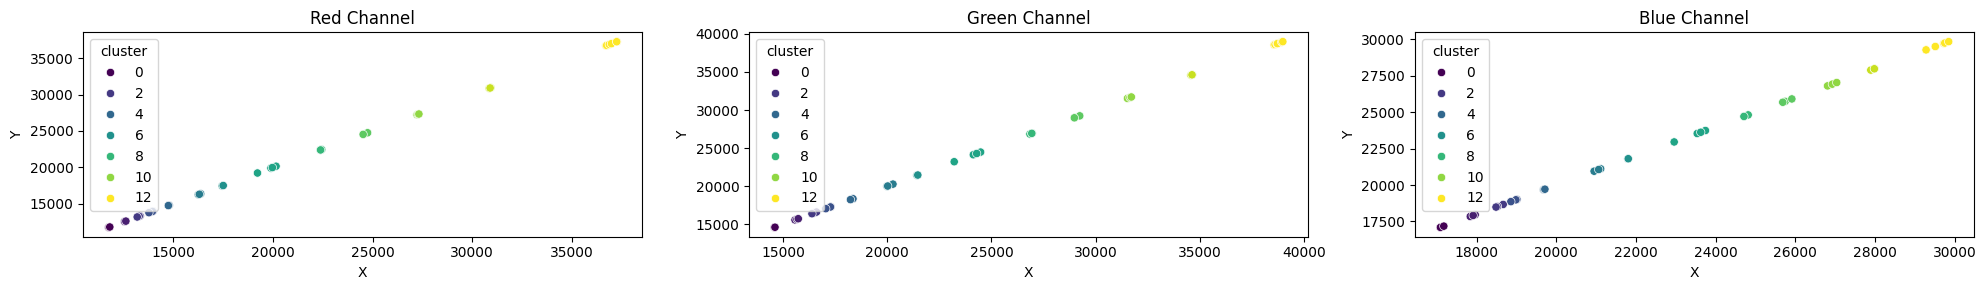

Number of outliers detected: 1
Number of non-outliers detected: 42


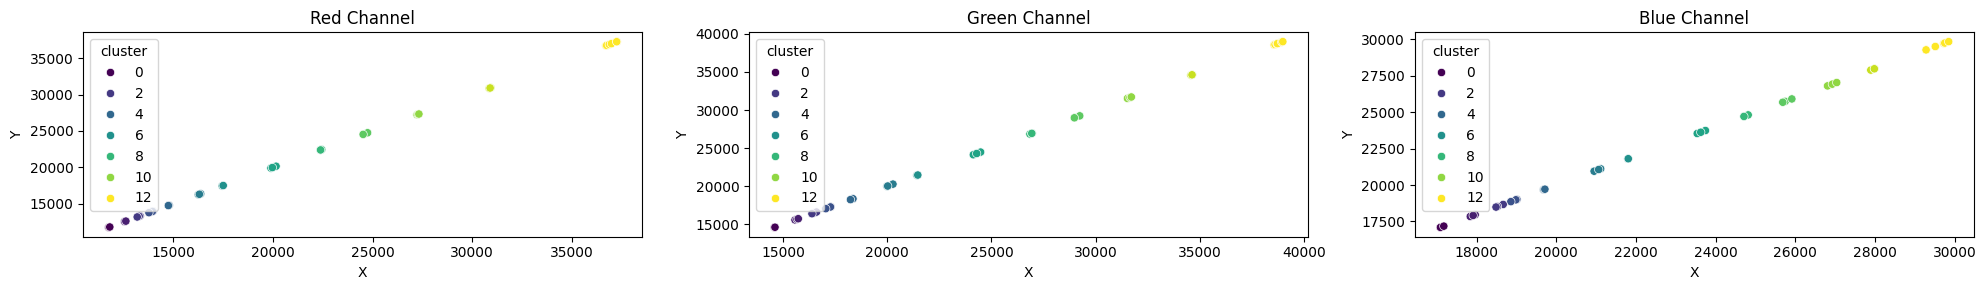

In [131]:
#directory = '/content/drive/MyDrive/calib'
directory = '/content/drive/MyDrive/trabajo/peliculas01'
image_paths = []
image_rgb_values = []
colors_std_list = []
rad_list = [0, 0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]


def detect_squares(image_path, scale_factor=0.5):
    """detect_squares toma como parametros la direccion de una imagen y un factor de
    escalado la funcion lleva a cabo la detección de recuadros y calcula la respuesta
    en los canales rgb de la imagen"""

    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    strip_list = []
    std_list = []

    if image is None:
        raise ValueError(f"Image not found at {image_path}")

    if image.dtype != np.uint16:
        raise ValueError(f"Image at {image_path} is not a 16-bit image")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 180 * 256, 65535, cv2.THRESH_BINARY_INV)

    # Convert the thresholded image to 8-bit
    thresh_8bit = cv2.convertScaleAbs(thresh, alpha=(255.0 / 65535.0))

    contours, _ = cv2.findContours(thresh_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    output_image = image.copy()

    for contour in contours:
        one_square_color = []

        # Approximate the contour to a polygon
        epsilon = 0.1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            side_length = min(w, h)
            center_x, center_y = x + w // 2, y + h // 2

            shrunken_side_length = int(side_length * scale_factor)
            shrunken_x = center_x - shrunken_side_length // 2
            shrunken_y = center_y - shrunken_side_length // 2

            shrunken_contour = np.array([
                [shrunken_x, shrunken_y],
                [shrunken_x + shrunken_side_length, shrunken_y],
                [shrunken_x + shrunken_side_length, shrunken_y + shrunken_side_length],
                [shrunken_x, shrunken_y + shrunken_side_length]
            ]).reshape((-1, 1, 2))

            cv2.drawContours(output_image, [shrunken_contour], 0, (0, 65535, 0), 1)

            mask = np.zeros_like(gray, dtype=np.uint8)
            cv2.drawContours(mask, [shrunken_contour], -1, 255, -1)

            mean_color = cv2.mean(image, mask=mask)
            mean_color_rgb = (mean_color[2], mean_color[1], mean_color[0])

            one_square_color.append(mean_color[2])
            one_square_color.append(mean_color[1])
            one_square_color.append(mean_color[0])

            # Extract RGB values within the masked area
            masked_pixels = cv2.bitwise_and(image, image, mask=mask)
            r_values = masked_pixels[:, :, 2][mask == 255]
            g_values = masked_pixels[:, :, 1][mask == 255]
            b_values = masked_pixels[:, :, 0][mask == 255]

            # Calculate the standard deviation of RGB values
            r_std = np.std(r_values)
            g_std = np.std(g_values)
            b_std = np.std(b_values)

            std_list.append([r_std, g_std, b_std])

        strip_list.append(one_square_color)

    image_8bit = cv2.convertScaleAbs(image, alpha=(255.0 / 65535.0))
    output_image_8bit = cv2.convertScaleAbs(output_image, alpha=(255.0 / 65535.0))

    """plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image_8bit, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title('Traced Silhouettes with Average Colors')
    plt.imshow(cv2.cvtColor(output_image_8bit, cv2.COLOR_BGR2RGB))
    plt.show()"""

    return strip_list, std_list


for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        image_paths.append(f)
        list1, list2 = detect_squares(f)
        image_rgb_values.append(list1)

        for rgb_values, std_values in zip(list1, list2):
            colors_std_list.append({
                'r': rgb_values[0],
                'g': rgb_values[1],
                'b': rgb_values[2],
                'std_r': std_values[0],
                'std_g': std_values[1],
                'std_b': std_values[2]
            })

colors_std = pd.DataFrame(colors_std_list)

colors = colors_std[['r', 'g', 'b']].apply(np.log10)
colors_np = colors.to_numpy()
num_clusters = 13

kmeans = KMeans(n_clusters=num_clusters, random_state=8, n_init=10)
kmeans.fit(colors_np)

labels = kmeans.labels_
colors_std['cluster'] = labels

# Ordering the clusters
cluster_means = colors_std.groupby('cluster')[['r', 'g', 'b']].mean()
cluster_means['mean_rgb'] = cluster_means.mean(axis=1)
sorted_clusters = cluster_means.sort_values('mean_rgb').index
cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
colors_std['cluster'] = colors_std['cluster'].map(cluster_mapping)

# Recalculate the cluster centers based on the new ordered labels
new_centers = np.zeros_like(kmeans.cluster_centers_)
for old_label, new_label in cluster_mapping.items():
    new_centers[new_label] = kmeans.cluster_centers_[old_label]

# Plot the ordered clusters
plt.figure(figsize=(20, 3))

plt.subplot(1, 3, 1)
sns.scatterplot(data=colors_std, x='r', y='r', hue='cluster', palette='viridis')
plt.title('Red Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 3, 2)
sns.scatterplot(data=colors_std, x='g', y='g', hue='cluster', palette='viridis')
plt.title('Green Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 3, 3)
sns.scatterplot(data=colors_std, x='b', y='b', hue='cluster', palette='viridis')
plt.title('Blue Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

# Calculate distances and detect outliers
distances = pairwise_distances_argmin_min(colors_np, new_centers)[1]
cluster_std = np.zeros(num_clusters)

for cluster in range(num_clusters):
    cluster_distances = distances[labels == cluster]
    cluster_std[cluster] = np.std(cluster_distances)

outliers = np.zeros(len(colors_np), dtype=bool)
for cluster in range(num_clusters):
    cluster_distances = distances[labels == cluster]
    threshold = np.mean(cluster_distances) + 1.5 * cluster_std[cluster]
    outliers[labels == cluster] = cluster_distances > threshold

non_outliers_std = colors_std[~outliers].reset_index(drop=True)
outliers_std = colors_std[outliers].reset_index(drop=True)

non_outlier_colors_np = non_outliers_std[['r', 'g', 'b']].apply(np.log10).to_numpy()

kmeans.fit(non_outlier_colors_np)
new_labels = kmeans.labels_

non_outliers_std['cluster'] = new_labels

# Calculate the mean RGB response for each cluster (non-outliers)
cluster_means_non_outliers = non_outliers_std.groupby('cluster')[['r', 'g', 'b']].mean()
cluster_means_non_outliers['mean_rgb'] = cluster_means_non_outliers.mean(axis=1)

# Sort clusters by mean RGB response (non-outliers)
sorted_clusters_non_outliers = cluster_means_non_outliers.sort_values('mean_rgb').index

# Create a mapping from old cluster labels to new ordered labels (non-outliers)
cluster_mapping_non_outliers = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters_non_outliers)}

# Reassign the cluster labels according to the sorted order (non-outliers)
non_outliers_std['cluster'] = non_outliers_std['cluster'].map(cluster_mapping_non_outliers)

# Recalculate the cluster centers based on the new ordered labels (non-outliers)
new_centers_non_outliers = np.zeros_like(kmeans.cluster_centers_)
for old_label, new_label in cluster_mapping_non_outliers.items():
    new_centers_non_outliers[new_label] = kmeans.cluster_centers_[old_label]

print("Number of outliers detected:", len(outliers_std))
print("Number of non-outliers detected:", len(non_outliers_std))

# Plot the ordered clusters for non-outliers
plt.figure(figsize=(20, 3))

plt.subplot(1, 3, 1)
sns.scatterplot(data=non_outliers_std, x='r', y='r', hue='cluster', palette='viridis')
plt.title('Red Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 3, 2)
sns.scatterplot(data=non_outliers_std, x='g', y='g', hue='cluster', palette='viridis')
plt.title('Green Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 3, 3)
sns.scatterplot(data=non_outliers_std, x='b', y='b', hue='cluster', palette='viridis')
plt.title('Blue Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()


Calculating uncertainty

In [132]:
non_outliers_std.sort_values(by='r', ascending = False, inplace=True)
non_outliers_std = non_outliers_std.reset_index(drop=True)
centroids = pd.DataFrame(new_centers_non_outliers, columns = ['r', 'g', 'b']).sort_values(by = 'r', ascending = False)
for color in ['r', 'g', 'b']:
    centroids[f'{color}'] = centroids[color].apply(lambda x: 10**x)

# Calculate weighted average
def weighted_mean(cluster_group):
    return pd.Series({
        'new_r': ((cluster_group['r'] * (1 / (cluster_group['std_r']**2))).sum())/ ((1 / (cluster_group['std_r']**2)).sum()),
        'new_g': ((cluster_group['g'] * (1 / (cluster_group['std_g']**2))).sum())/ ((1 / (cluster_group['std_g']**2)).sum()),
        'new_b':((cluster_group['b'] * (1 / (cluster_group['std_b']**2))).sum())/ ((1 / (cluster_group['std_b']**2)).sum())
    })


summed_std = non_outliers_std.groupby('cluster').apply(weighted_mean).reset_index()
centroids = pd.concat([centroids, summed_std[['new_r', 'new_g', 'new_b']]], axis=1)
def sum_inverse_square_std(cluster_group):
    return pd.Series({
        'std_r': np.sqrt(1/ ((1 / (cluster_group['std_r']**2)).sum())),
        'std_g': np.sqrt(1/((1 / (cluster_group['std_g']**2)).sum())),
        'std_b': np.sqrt(1/((1 / (cluster_group['std_b']**2)).sum()))
    })


summed_std = non_outliers_std.groupby('cluster').apply(sum_inverse_square_std).reset_index()
centroids = pd.concat([centroids, summed_std[['std_r', 'std_g', 'std_b']]], axis=1)

#Applying transformation to the std and the PV
centroids.reset_index(drop=True, inplace=True)
pixelV_df = centroids.copy()

for color in ['r', 'g', 'b']:
  s0 = centroids[f'std_{color}'][0]
  i0 = centroids[f'new_{color}'][0]
  for item in centroids[f'std_{color}']:
    centroids[f'std_{color}'][list(centroids[f'std_{color}']).index(item)] = ((1 /np.log(10)) * (np.sqrt((s0**2/(i0**2))+
        (item**2/(centroids[f'new_{color}'][list(centroids[f'std_{color}']).index(item)])**2))))


centroids.reset_index(drop=True, inplace=True)
for color in ['r', 'g', 'b']:
    centroids[f'{color}'] = centroids[color].apply(lambda x: -1 * np.log10(x /centroids[f'{color}'][0]))
    centroids[f'new_{color}'] = centroids[f'new_{color}'].apply(lambda x: -1 * np.log10(x /centroids[f'new_{color}'][0]))


# Pixel Value analysis

r fit report:
[[Model]]
    Model(devic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 162
    # data points      = 13
    # variables        = 3
    chi-square         = 0.22031543
    reduced chi-square = 0.02203154
    Akaike info crit   = -47.0093765
    Bayesian info crit = -45.3145285
    R-squared          = 0.99839860
[[Variables]]
    a: -2.81528989 +/- 0.24120176 (8.57%) (init = 20000)
    b:  84729.1518 +/- 6060.47936 (7.15%) (init = 1)
    c:  5282.97613 +/- 390.184895 (7.39%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c) = -0.9842
    C(a, b) = -0.9625
    C(a, c) = +0.9099
g fit report:
[[Model]]
    Model(devic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 13
    # variables        = 3
    chi-square         = 0.21662405
    reduced chi-square = 0.02166240
    Akaike info crit   = -47.2290368
    Bayesian info crit = -45.5341888
    R-squared        

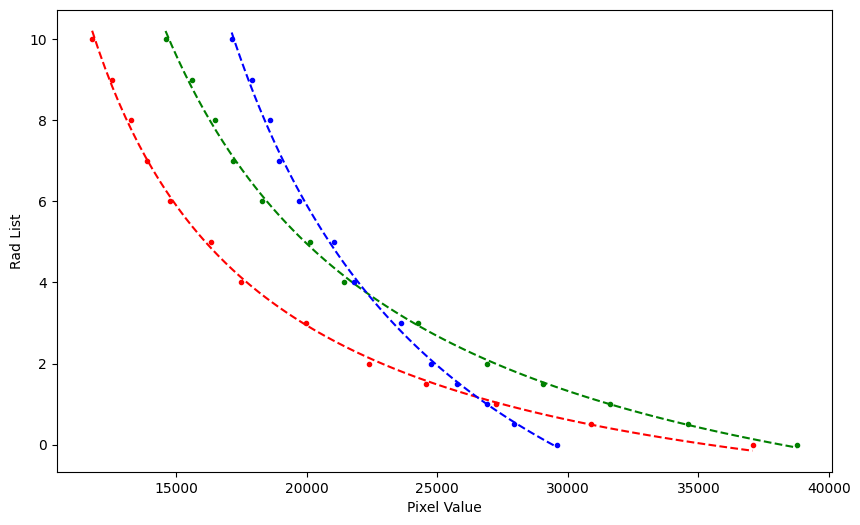

In [133]:
def devic(x, a, b, c):
    return a + b / (x - c)

def fit_and_plot(color, rad_list):
    x_data = pixelV_df[f'new_{color}'].values
    y_data = np.array(rad_list)

    model = Model(devic)

    params = model.make_params(a=20000., b=1., c=1.)

    result = model.fit(y_data, params, x=x_data)

    print(f"{color} fit report:")
    print(result.fit_report())

    a = result.params['a'].value
    b = result.params['b'].value
    c = result.params['c'].value

    curvey = np.linspace(min(x_data), max
    (x_data), 100)
    curvex = devic(curvey, a, b, c)

    plt.plot(x_data, y_data, '.', label=f'{color} data', color = color)
    plt.plot(curvey, curvex, '--', label=f'{color} fit', color = color)
    return result


plt.figure(figsize=(10, 6))
results_pv = []
for color in ['r', 'g', 'b']:
    result = fit_and_plot(color, rad_list)
    results_pv.append(result)

plt.xlabel('Pixel Value')
plt.ylabel('Rad List')
plt.show()


Uncertainty analysis one channel

Fitting parameters:
[-2.81529201e+00  8.47292096e+04  5.28297235e+03]
Residuals sum of squares:
0.22031542898430082
Dfit: [-0.15009229  0.49386506  1.0387208   1.57616221  2.13371498  2.95093451
  4.13647251  4.85737205  6.11984277  7.02067411  7.79392396  8.82245623
 10.2059531 ]
ufit:  [-205.99099703   69.1852238    35.87353975   25.75052597   20.75982006
   17.00242034   14.40316982   13.54484229   12.67619132   12.34886654
   12.19031687   12.10270714   12.14068294]
uexp:  [-5.52302827  1.83158821  1.20493737  0.96147113  0.96588934  0.83337225
  1.1532836   1.0420503   1.031548    1.02840256  0.95016918  1.08587764
  1.1302562 ]
utot:  [206.06502541  69.20946401  35.89377004  25.76846938  20.78227781
  17.02283193  14.44926863  13.58486737  12.7180941   12.39161477
  12.22729107  12.15132299  12.19318094]
a = -2.815 ± 0.241
b = 84729.210 ± 6060.479
c = 5282.972 ± 390.185
[1.62500172e+00 4.08297750e+04 2.62873157e+03]


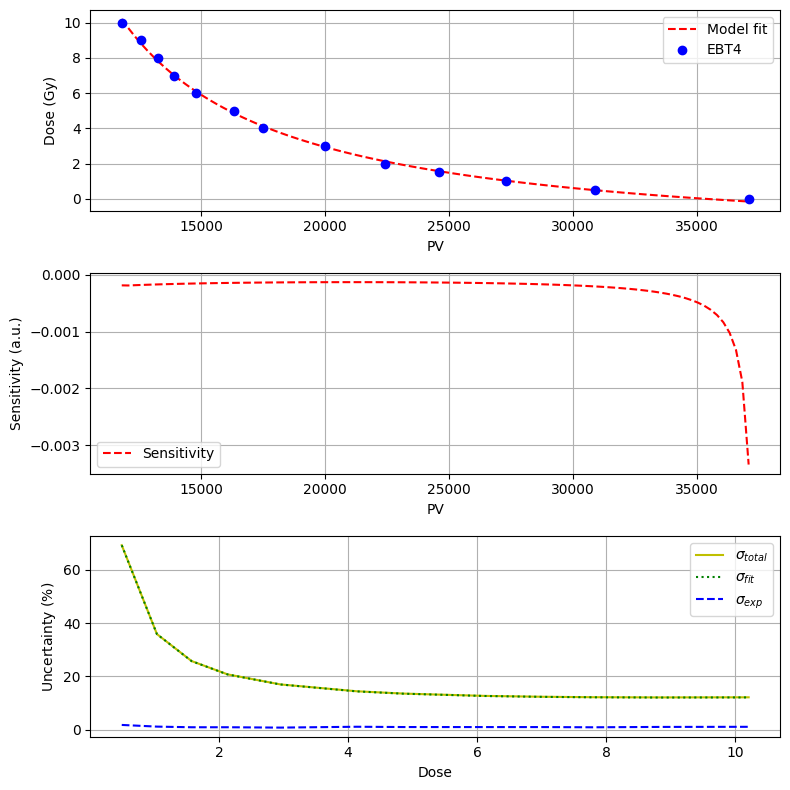

In [134]:
plt.rcParams['text.usetex'] = False

def pv_fit(x, a, b, c):
    return a + b / (x - c)

dosis = np.array(rad_list)
sigma = np.array(pixelV_df['std_r'])
pv = np.array(pixelV_df['new_r'])

popt_pv, pcov = curve_fit(pv_fit, pv, dosis, p0=(1000., 1., 1.), absolute_sigma=True)

print("Fitting parameters:")
print(popt_pv)
residuals = dosis - pv_fit(pv, *popt_pv)
fres = sum(residuals**2)
print("Residuals sum of squares:")
print(fres)

curvex = np.linspace(min(pv), max(pv), 100)
curvey = pv_fit(curvex, *popt_pv)

curvex_sens = np.linspace(min(pv), max(pv) - 2000, 100)
curvey_sens = pv_fit(curvex_sens, *popt_pv)
dy = np.gradient(curvey_sens)
dx = np.gradient(curvex_sens)

d = (1/curvey_sens)*dy/dx
fig, ax = plt.subplots(3, 1, figsize=(8, 8))
ax[0].plot(curvex, curvey, '--r', label='Model fit')
ax[0].plot(pv, dosis, 'ob', label='EBT4')
ax[1].plot(curvex, d, '--r', label='Sensitivity')

ax[0].set_xlabel('PV')
ax[0].set_ylabel('Dose (Gy)')
ax[1].set_xlabel('PV')
ax[1].set_ylabel('Sensitivity (a.u.)')
ax[2].set_xlabel('Dose')
ax[2].set_ylabel('Uncertainty ($\%$)')

a, b, c = popt_pv
a_std_dev, b_std_dev, c_std_dev = results_pv[0].params['a'].stderr, results_pv[0].params['b'].stderr, results_pv[0].params['c'].stderr

dfit = pv_fit(pv, *popt_pv)
print("Dfit:", dfit)

uexp = np.sqrt((-b / ((pv - c) ** 2)) ** 2 * sigma ** 2) / dfit * 100
ufit = np.sqrt(a_std_dev ** 2 + (((1 / (pv - c)) * b_std_dev)** 2) + (((b / (pv - c) ** 2) * c_std_dev) ** 2)) / dfit * 100
utotal = np.sqrt(ufit ** 2 + uexp ** 2)

ax[2].plot(dfit[1:], utotal[1:], '-y', label='$\sigma_{total}$')
ax[2].plot(dfit[1:], ufit[1:], ':g', label='$\sigma_{fit}$')
ax[2].plot(dfit[1:], uexp[1:], '--b', label='$\sigma_{exp}$')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

print("ufit: ", ufit)
print("uexp: ", uexp)
print("utot: ", utotal)

print(f"a = {a:.3f} ± {a_std_dev:.3f}")
print(f"b = {b:.3f} ± {b_std_dev:.3f}")
print(f"c = {c:.3f} ± {c_std_dev:.3f}")

ux = np.sqrt(np.diag(pcov))
print(ux)

plt.tight_layout()
plt.show()


Fitting parameters for red:
[-2.81529019e+00  8.47291601e+04  5.28297559e+03]
Residuals sum of squares for red:
0.22031542898313905
Dfit for red: [-0.15009176  0.49386537  1.03872094  1.5761622   2.13371485  2.95093423
  4.13647212  4.85737163  6.11984243  7.02067389  7.79392388  8.82245643
 10.20595379]
Uncertainties for red:
[-205.99173912   69.18518456   35.87353754   25.75052836   20.75982359
   17.00242424   14.40317375   13.5448462    12.67619526   12.34887054
   12.19032096   12.10271139   12.14068751]
[-5.52304588  1.83158647  1.20493686  0.9614709   0.9658892   0.83337221
  1.15328364  1.04205039  1.03154816  1.02840276  0.95016941  1.08587795
  1.13025659]
[206.06576771  69.20942474  35.89376782  25.76847177  20.78228133
  17.02283582  14.44927255  13.58487128  12.71809804  12.39161878
  12.22729517  12.15132725  12.19318552]
a = -2.815 ± 0.241
b = 84729.160 ± 6060.479
c = 5282.976 ± 390.185
[1.62501519e+00 4.08303813e+04 2.62876208e+03]
Fitting parameters for green:
[-3.9939

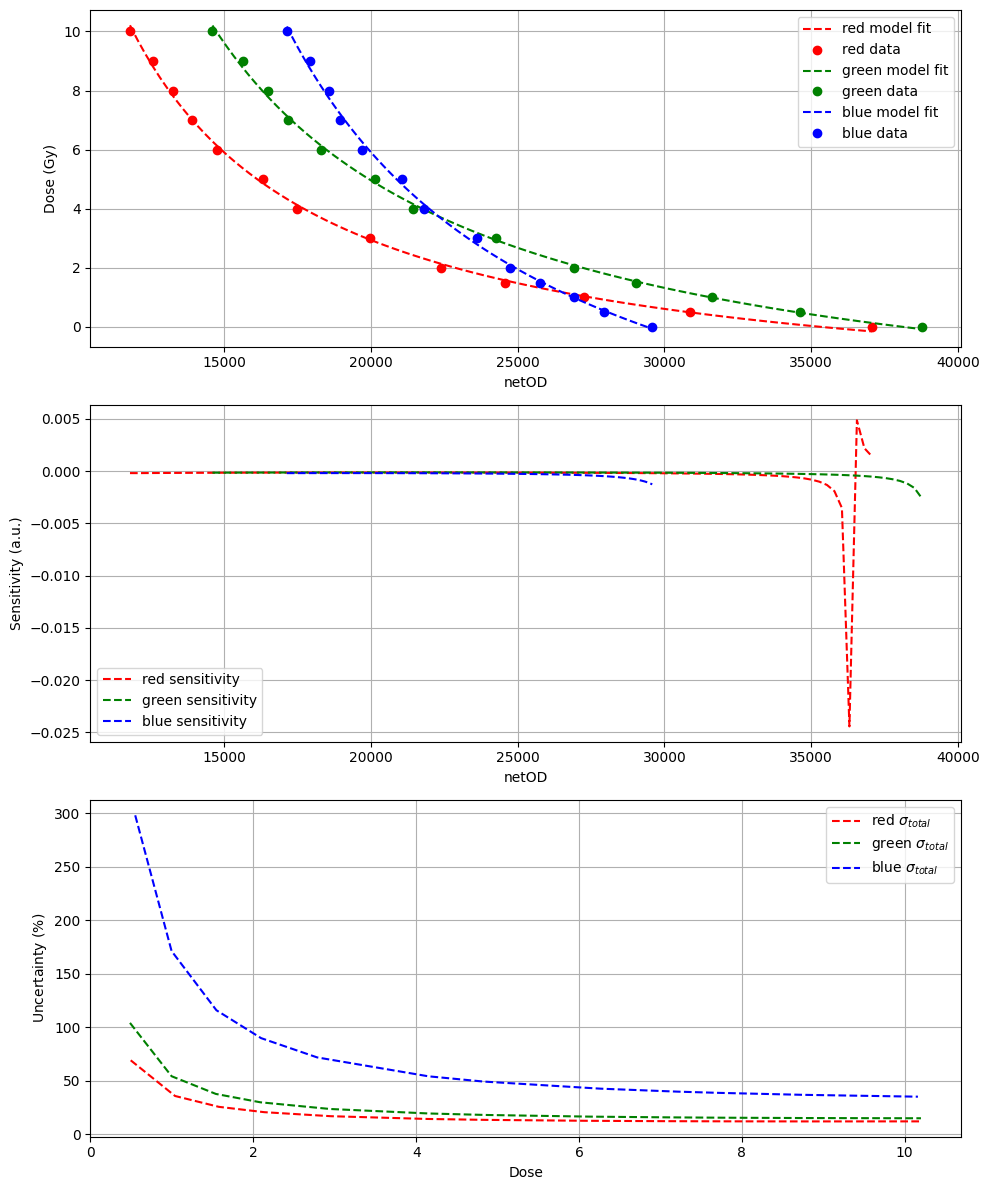

In [135]:
plt.rcParams['text.usetex'] = False


def pv_fit(x, a, b, c):
    return a + b / (x - c)

dosis = np.array(rad_list)

colors = ['r', 'g', 'b']
color_labels = {'r': 'red', 'g': 'green', 'b': 'blue'}

fig, ax = plt.subplots(3, 1, figsize=(10, 12))

for i, color in enumerate(colors):
    pv = np.array(pixelV_df[f'new_{color}'])
    sigma = np.array(pixelV_df[f'std_{color}'])
    popt, pcov = curve_fit(pv_fit, pv, dosis, p0=(100., 10., 1), absolute_sigma=True)

    print(f"Fitting parameters for {color_labels[color]}:")
    print(popt)
    residuals = dosis - pv_fit(pv, *popt)
    fres = sum(residuals**2)
    print(f"Residuals sum of squares for {color_labels[color]}:")
    print(fres)

    curvex = np.linspace(min(pv), max(pv), 100)
    curvey = pv_fit(curvex, *popt)


    curvex_sens = np.linspace(min(pv), max(pv) - 1000, 100)
    curvey_sens = pv_fit(curvex_sens, *popt)
    dy = np.gradient(curvey_sens)
    dx = np.gradient(curvex_sens)
    d = (1 / curvey_sens) * dy / dx

    # Plotting the model fit and data
    ax[0].plot(curvex, curvey, '--', label=f'{color_labels[color]} model fit', color=color)
    ax[0].plot(pv, dosis, 'o', label=f'{color_labels[color]} data', color=color)
    ax[1].plot(curvex, d, '--', label=f'{color_labels[color]} sensitivity', color=color)

    a, b, c = popt
    a_std_dev = results_pv[i].params['a'].stderr
    b_std_dev = results_pv[i].params['b'].stderr
    c_std_dev = results_pv[i].params['c'].stderr


    dfit = pv_fit(pv, *popt)
    print(f"Dfit for {color_labels[color]}:", dfit)

    uexp = np.sqrt((-b / ((pv - c) ** 2)) ** 2 * sigma ** 2) / dfit * 100
    ufit = np.sqrt(a_std_dev ** 2 + (((1 / (pv - c)) * b_std_dev)** 2) + (((b / (pv - c) ** 2) * c_std_dev) ** 2)) / dfit * 100
    utotal = np.sqrt(ufit ** 2 + uexp ** 2)

    ax[2].plot(dfit[1:], utotal[1:], '--', label=f'{color_labels[color]} $\sigma_{{total}}$', color=color)
    #ax[2].plot(dfit, ufit, '-', label=f'{color_labels[color]} $\sigma_{{fit}}$', color=color)
    #ax[2].plot(dfit, uexp, ':', label=f'{color_labels[color]} $\sigma_{{exp}}$', color=color)

    print(f"Uncertainties for {color_labels[color]}:")
    print(ufit)
    print(uexp)
    print(utotal)
    print(f"a = {a:.3f} ± {a_std_dev:.3f}")
    print(f"b = {b:.3f} ± {b_std_dev:.3f}")
    print(f"c = {c:.3f} ± {c_std_dev:.3f}")


    ux = np.sqrt(np.diag(pcov))
    print(ux)
    print("===================================================================")

ax[0].set_xlabel('netOD')
ax[0].set_ylabel('Dose (Gy)')
ax[1].set_xlabel('netOD')
ax[1].set_ylabel('Sensitivity (a.u.)')
ax[2].set_xlabel('Dose')
ax[2].set_ylabel('Uncertainty ($\%$)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

plt.tight_layout()
plt.show()


# NetOD Analysis

/usr/local/lib/python3.10/dist-packages/lmfit/model.py:1123: UserWarning: The keyword argument model does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


r fit report:
[[Model]]
    Model(devic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.15804845
    reduced chi-square = 0.01436804
    Akaike info crit   = -53.3274391
    Bayesian info crit = -52.1975404
    R-squared          = 0.99885120
[[Variables]]
    a:  6.74179083 +/- 0.29636178 (4.40%) (init = 100)
    b:  55.0158226 +/- 1.62054606 (2.95%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.9403
g fit report:
[[Model]]
    Model(devic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.20919385
    reduced chi-square = 0.01901762
    Akaike info crit   = -49.6827628
    Bayesian info crit = -48.5528641
    R-squared          = 0.99847944
[[Variables]]
    a:  11.2543107 +/- 0.40489851 (3.60%) (init = 100)
    b:  71.098516

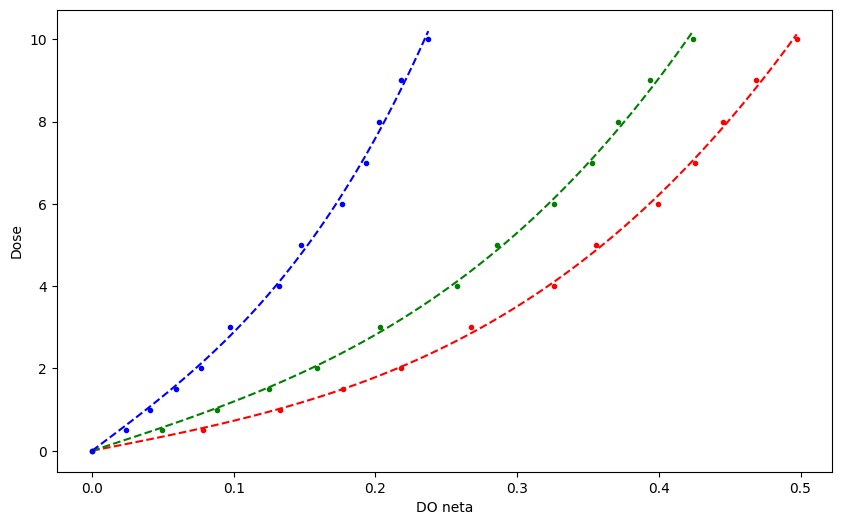

In [136]:
# log10(pv/fondo)
# a*x + b*x**n

def devic(x, a, b):
    return (a*x) + (b*x**3)

def fit_and_plot(color, rad_list):

    x_data = centroids[f'{color}'].values
    y_data = np.array(rad_list)
    # Create a Model object
    model = Model(devic)

    # Create a Parameters object and set initial guesses
    params = model.make_params(a=100., b=10.)
    # Fit the model to the data
    result = model.fit(y_data, params, x=x_data, model = "leastsq")

    # Print the fit report
    print(f"{color} fit report:")
    print(result.fit_report())

    a = result.params['a'].value
    b = result.params['b'].value

    curvey = np.linspace(min(x_data), max(x_data), 100)
    curvex = devic(curvey, a, b)

    plt.plot(x_data, y_data, '.', label=f'{color} data', color = color)
    plt.plot(curvey, curvex, '--', label=f'{color} fit', color = color)

    return result


plt.figure(figsize=(10, 6))
results_netOD = []
for color in ['r', 'g', 'b']:
    result = fit_and_plot(color, rad_list)
    results_netOD.append(result)

plt.xlabel('DO neta')
plt.ylabel('Dose')
plt.show()


Uncertainty analysis one channel

Fitting parameters:
[11.26795548 70.99717518]
Residuals sum of squares:
0.19815875025457028
Dfit: [-0.          0.56260827  1.0463549   1.55371568  2.06850455  2.89592358
  4.10712352  4.83406233  6.12232827  7.10984607  7.82465297  8.79995724
 10.19202921]
[       nan 3.54002389 3.43048694 3.29263082 3.15870277 2.98759118
 2.84031387 2.79644788 2.76974817 2.77629896 2.78958735 2.81473845
 2.85822915]
[      -inf 2.41861926 1.60030922 1.26288178 1.20338613 1.08401678
 1.30074748 1.18983098 1.10224507 1.02916499 1.00146717 1.11129468
 1.08469666]
[       nan 4.28736379 3.78539697 3.52651217 3.38016884 3.17817455
 3.12399214 3.03904895 2.98101478 2.96091481 2.96390521 3.02617389
 3.05712949]
a = 11.268 ± 0.405
b = 70.997 ± 3.086
[ 2.93333136 22.3541096 ]


<ipython-input-137-f796971fdc23>:25: RuntimeWarning: divide by zero encountered in divide
  d = (1 / curvey) * dy / dx
<ipython-input-137-f796971fdc23>:46: RuntimeWarning: invalid value encountered in divide
  ufit = np.sqrt((netOD * a_std_dev)**2 + netOD**6 * b_std_dev**2) / dfit * 100
<ipython-input-137-f796971fdc23>:47: RuntimeWarning: divide by zero encountered in divide
  uexp = np.sqrt((a + 3 * b * netOD**2)**2 * sigma**2) / dfit * 100


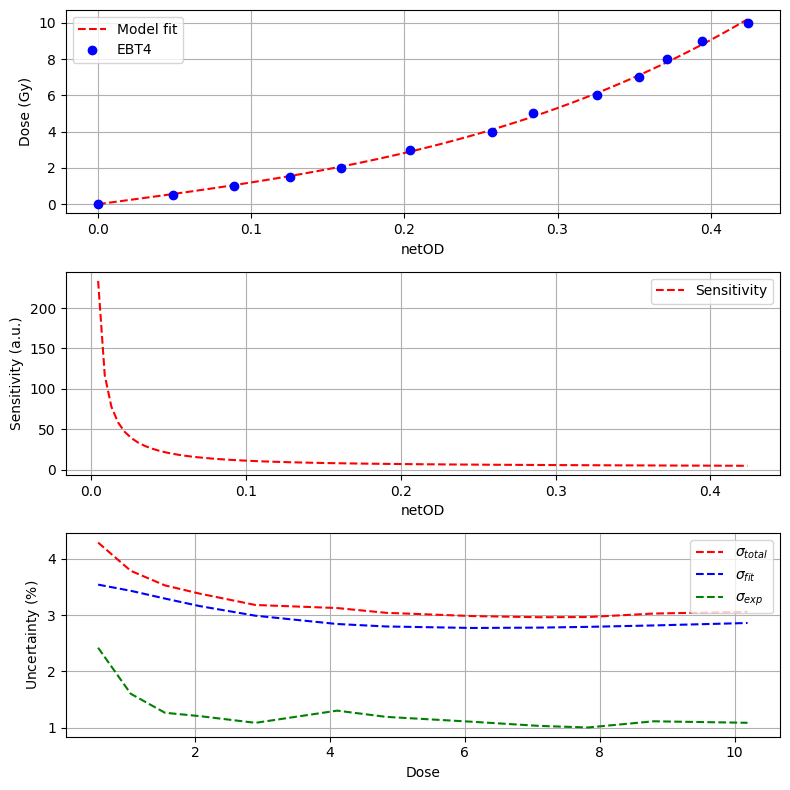

In [137]:
plt.rcParams['text.usetex'] = False

def devic(x, a, b):
    return (a*x) + (b*x**3)

dosis = np.array(rad_list)
sigma = np.array(centroids['std_g'])
netOD = np.array(centroids['new_g'])

popt, pcov = curve_fit(devic, netOD, dosis, p0=(100., 10.), absolute_sigma=True)

print("Fitting parameters:")
print(popt)
residuals = dosis - devic(netOD, *popt)
fres = sum(residuals**2)
print("Residuals sum of squares:")
print(fres)

curvex = np.linspace(min(netOD), max(netOD), 100)
curvey = devic(curvex, *popt)

dy = np.gradient(curvey)
dx = np.gradient(curvex)

d = (1 / curvey) * dy / dx

fig, ax = plt.subplots(3, 1, figsize=(8, 8))  # 3 rows, 1 column
ax[0].plot(curvex, curvey, '--r', label='Model fit')
ax[0].plot(netOD, dosis, 'ob', label='EBT4')
ax[1].plot(curvex[1:], d[1:], '--r', label='Sensitivity')

ax[0].set_xlabel('netOD')
ax[0].set_ylabel('Dose (Gy)')
ax[1].set_xlabel('netOD')
ax[1].set_ylabel('Sensitivity (a.u.)')
ax[2].set_xlabel('Dose')
ax[2].set_ylabel('Uncertainty ($\%$)')

a, b = popt
a_std_dev, b_std_dev = results_netOD[1].params['a'].stderr, results_netOD[1].params['b'].stderr


dfit = devic(netOD, *popt)
print("Dfit:", dfit)

ufit = np.sqrt((netOD * a_std_dev)**2 + netOD**6 * b_std_dev**2) / dfit * 100
uexp = np.sqrt((a + 3 * b * netOD**2)**2 * sigma**2) / dfit * 100
utotal = np.sqrt(ufit**2 + uexp**2)

ax[2].plot(dfit[1:], utotal[1:], '--r', label='$\sigma_{total}$')
ax[2].plot(dfit[1:], ufit[1:], '--b', label='$\sigma_{fit}$')
ax[2].plot(dfit[1:], uexp[1:], '--g', label='$\sigma_{exp}$')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

print(ufit)
print(uexp)
print(utotal)

print(f"a = {a:.3f} ± {a_std_dev:.3f}")
print(f"b = {b:.3f} ± {b_std_dev:.3f}")

ux = np.sqrt(np.diag(pcov))
print(ux)

plt.tight_layout()
plt.show()


Uncertainty analysis multiple channels

Fitting parameters for red:
[ 6.66657063 55.0776295 ]
Residuals sum of squares for red:
0.14906038610303549
Dfit for red: [-0.          0.55602105  1.02027079  1.50368641  2.0348994   2.85680018
  4.09965799  4.86352496  6.18548093  7.10312238  7.86823975  8.84975778
 10.10121923]
Uncertainties for red:
[       nan 4.22850338 3.89383975 3.57186222 3.29319012 2.99454293
 2.73509377 2.64162676 2.5442636  2.50564788 2.48461572 2.4676604
 2.45683249]
[      -inf 2.10627577 1.52855484 1.31029389 1.29146922 1.16315143
 1.41112271 1.28260745 1.22241945 1.18255606 1.08677343 1.15758078
 1.13912787]
[       nan 4.72404894 4.18311701 3.80461165 3.53737104 3.21250815
 3.0776623  2.93654113 2.82269137 2.77068766 2.71189818 2.72568177
 2.70806908]
a = 6.667 ± 0.296
b = 55.078 ± 1.621
[ 2.46828477 13.46115949]
Fitting parameters for green:
[11.26795548 70.99717518]
Residuals sum of squares for green:
0.19815875025457028
Dfit for green: [-0.          0.56260827  1.0463549   1.55371568  2.06850455  2.

<ipython-input-138-95a03bd8e559>:31: RuntimeWarning: divide by zero encountered in divide
  d = (1 / curvey) * dy / dx
<ipython-input-138-95a03bd8e559>:45: RuntimeWarning: invalid value encountered in divide
  ufit = np.sqrt((netOD * a_std_dev)**2 + netOD**6 * b_std_dev**2) / dfit * 100
<ipython-input-138-95a03bd8e559>:46: RuntimeWarning: divide by zero encountered in divide
  uexp = np.sqrt((a + 3 * b * netOD**2)**2 * sigma**2) / dfit * 100


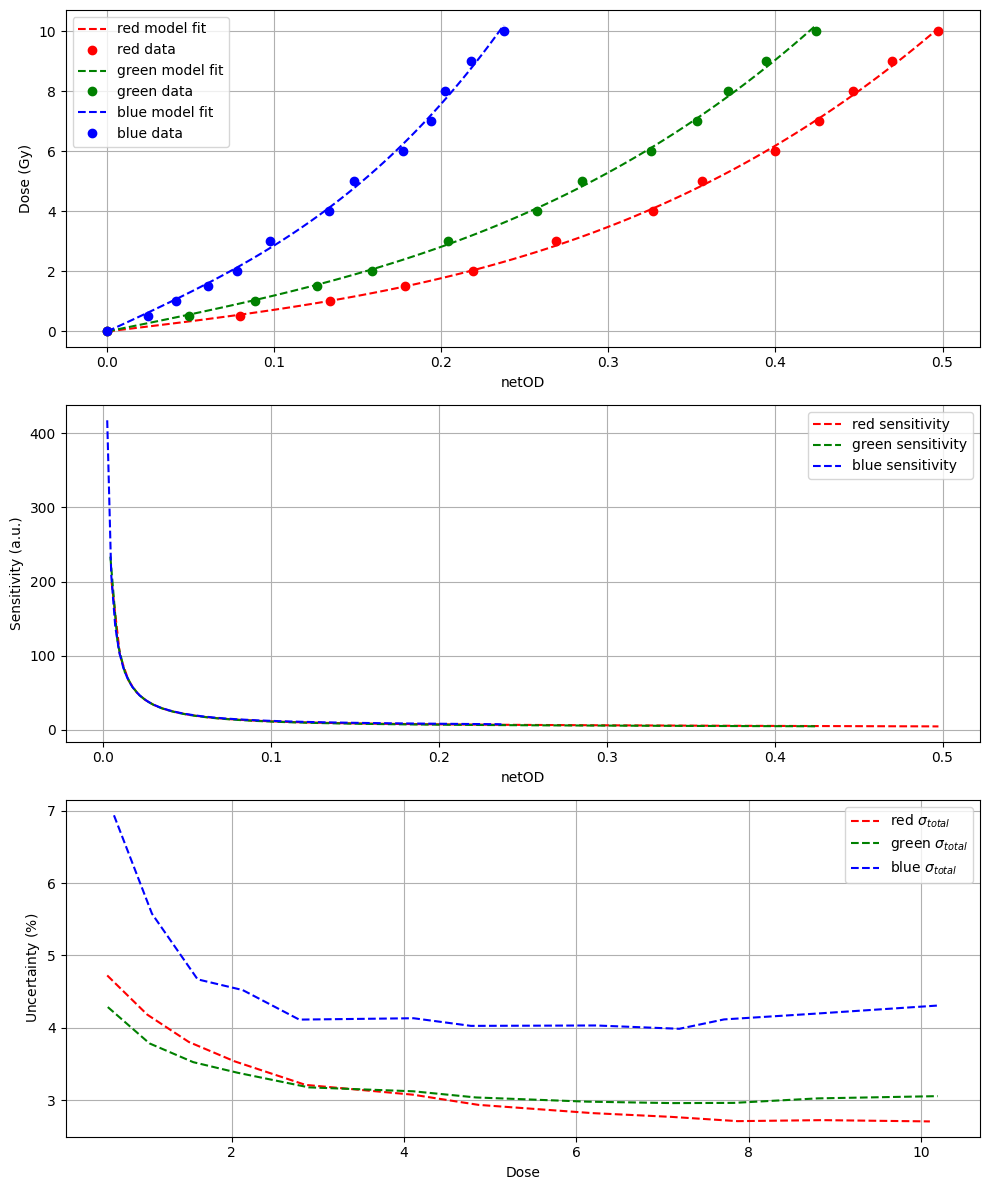

In [138]:
plt.rcParams['text.usetex'] = False

def devic(x, a, b):
    return (a * x) + (b * x**3)

dosis = np.array(rad_list)

colors = ['r', 'g', 'b']
color_labels = {'r': 'red', 'g': 'green', 'b': 'blue'}

fig, ax = plt.subplots(3, 1, figsize=(10, 12))

for i, color in enumerate(colors):
    netOD = np.array(centroids[f'new_{color}'])
    sigma = np.array(centroids[f'std_{color}'])

    popt, pcov = curve_fit(devic, netOD, dosis, p0=(100., 10.), absolute_sigma=True)

    print(f"Fitting parameters for {color_labels[color]}:")
    print(popt)
    residuals = dosis - devic(netOD, *popt)
    fres = sum(residuals**2)
    print(f"Residuals sum of squares for {color_labels[color]}:")
    print(fres)

    curvex = np.linspace(min(netOD), max(netOD), 100)
    curvey = devic(curvex, *popt)

    dy = np.gradient(curvey)
    dx = np.gradient(curvex)
    d = (1 / curvey) * dy / dx

    # Plotting the model fit and data
    ax[0].plot(curvex, curvey, '--', label=f'{color_labels[color]} model fit', color=color)
    ax[0].plot(netOD, dosis, 'o', label=f'{color_labels[color]} data', color=color)
    ax[1].plot(curvex, d, '--', label=f'{color_labels[color]} sensitivity', color=color)

    a, b = popt
    a_std_dev = results_netOD[i].params['a'].stderr
    b_std_dev = results_netOD[i].params['b'].stderr

    dfit = devic(netOD, *popt)
    print(f"Dfit for {color_labels[color]}:", dfit)

    ufit = np.sqrt((netOD * a_std_dev)**2 + netOD**6 * b_std_dev**2) / dfit * 100
    uexp = np.sqrt((a + 3 * b * netOD**2)**2 * sigma**2) / dfit * 100
    utotal = np.sqrt(ufit**2 + uexp**2)

    ax[2].plot(dfit[1:], utotal[1:], '--', label=f'{color_labels[color]} $\sigma_{{total}}$', color=color)
    #ax[2].plot(dfit, ufit, '-', label=f'{color_labels[color]} $\sigma_{{fit}}$', color=color)
    #ax[2].plot(dfit, uexp, ':', label=f'{color_labels[color]} $\sigma_{{exp}}$', color=color)

    print(f"Uncertainties for {color_labels[color]}:")
    print(ufit)
    print(uexp)
    print(utotal)
    print(f"a = {a:.3f} ± {a_std_dev:.3f}")
    print(f"b = {b:.3f} ± {b_std_dev:.3f}")

    ux = np.sqrt(np.diag(pcov))
    print(ux)
    print("===================================================================")

ax[0].set_xlabel('netOD')
ax[0].set_ylabel('Dose (Gy)')
ax[1].set_xlabel('netOD')
ax[1].set_ylabel('Sensitivity (a.u.)')
ax[2].set_xlabel('Dose')
ax[2].set_ylabel('Uncertainty ($\%$)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

plt.tight_layout()
plt.show()


In [150]:
cluster_to_dose = {cluster: dose for cluster, dose in zip(np.unique(non_outliers_std['cluster']), rad_list)}

nn_data = non_outliers_std.drop('cluster', axis=1)
nn_data = nn_data.sort_values(by ="r")
nn_data = nn_data.reset_index(drop=True)

doses = non_outliers_std['cluster'].map(cluster_to_dose)



X_train, X_test, y_train, y_test = train_test_split(nn_data, doses, test_size=0.2, random_state=42)

scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ('regressor', 'passthrough')])

seed = 42
param_grid = [
    {'regressor': [MLPRegressor(random_state=seed, max_iter=300)],
     'regressor__solver': ['lbfgs', 'sgd', 'adam'],
     'regressor__learning_rate_init': np.logspace(-3, -1, 6)}
]

grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, cv=5, scoring='r2', refit='r2')
grid_search.fit(X_train, y_train)

print("Tuned hyperparameters and best model:", grid_search.best_params_)
print("R2 Score on training set:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print("R2 Score on test set:", r2_score(y_test, y_pred))
print("Mean Squared Error on test set:", mean_squared_error(y_test, y_pred))




Tuned hyperparameters and best model: {'regressor': MLPRegressor(learning_rate_init=0.00630957344480193, max_iter=300,
             random_state=42, solver='sgd'), 'regressor__learning_rate_init': 0.00630957344480193, 'regressor__solver': 'sgd'}
R2 Score on training set: 0.972618357660185
R2 Score on test set: 0.9829624726206201
Mean Squared Error on test set: 0.18362668397776138


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.86741645 0.92049311 0.94860729 0.86741645 0.92632252 0.90974696
 0.86741645 0.97261836 0.85579828 0.86741645 0.96833337 0.9078742
 0.86741645 0.94798995 0.95748157 0.86741645        nan 0.93852249]
  warnings.warn(


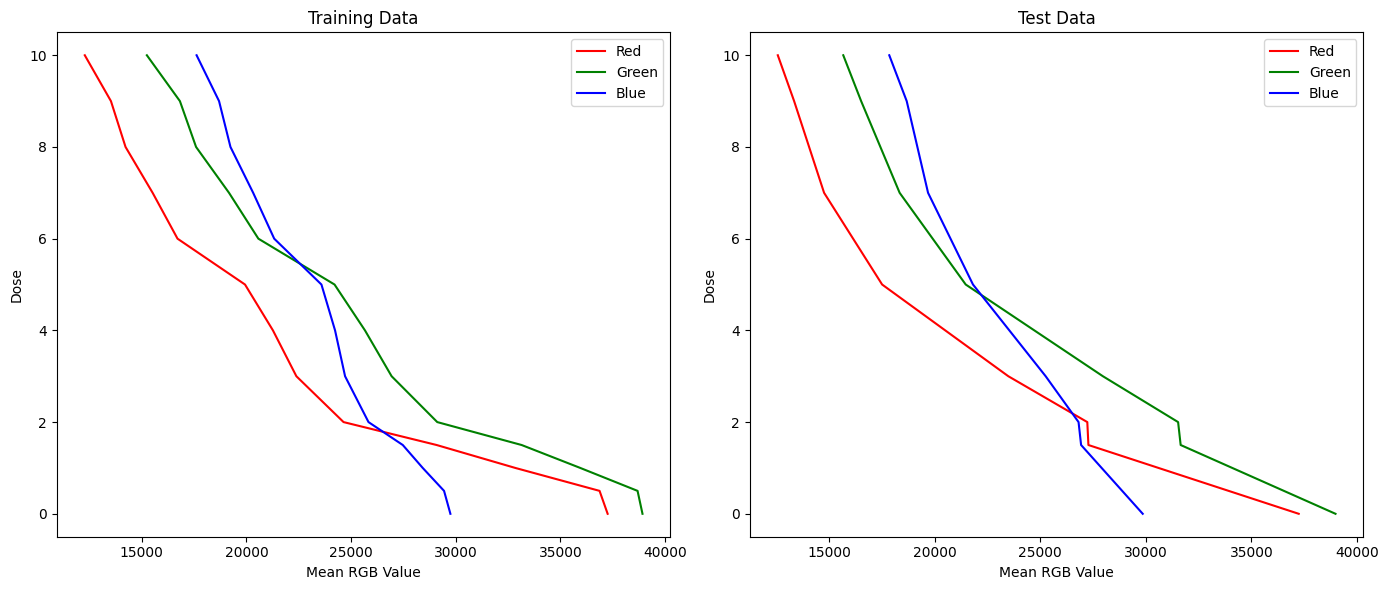

In [145]:
def plot_rgb_activation(data, doses, ax):
    unique_doses = np.unique(doses)
    mean_rgb_values = []

    for dose in unique_doses:
        mask = doses == dose
        mean_rgb_values.append(data[mask].mean(axis=0))

    mean_rgb_values = np.array(mean_rgb_values)
    ax.plot(mean_rgb_values[:, 0],unique_doses , label='Red', color='r')
    ax.plot(mean_rgb_values[:, 1],unique_doses , label='Green', color='g')
    ax.plot(mean_rgb_values[:, 2],unique_doses , label='Blue', color='b')
    ax.set_xlabel('Mean RGB Value')
    ax.set_ylabel('Dose')
    ax.legend()

# Create plots for training and test data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
plot_rgb_activation(X_train, y_train, ax1)
ax1.set_title('Training Data')

plot_rgb_activation(X_test, y_test, ax2)
ax2.set_title('Test Data')

plt.tight_layout()
plt.show()